In [7]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
import sys
import tensorflow as tf

# Set the main project folder to python path so we can import our homemade modules
PROJECT_FOLDER = Path().absolute().parent
sys.path.append(str(PROJECT_FOLDER))

from game_mechanics.engine import DataBase
import game_mechanics as gm 

# Data Load

In [4]:
DATA_FOLDER = PROJECT_FOLDER / 'data'
DATA_FILE = DATA_FOLDER / 'master_db.json'
db = DataBase(DATA_FILE)
print(f'Data size: {len(db.data)}')

Data size: 62626


In [5]:
raw_data = pd.DataFrame(db.data)
print(raw_data.shape)
raw_data.head(2)

(62626, 9)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN


# Data Clean

In [6]:
data_df_1 = raw_data.copy()

# Add indicator variable if player one is the winner
data_df_1['player_one_win'] = data_df_1.winner_id == data_df_1.player_one_id

print(data_df_1.shape)
data_df_1.head(2)

(62626, 10)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN,False
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN,False


In [ ]:
data_df_1.tail(2)

,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
62624,1732806409274295-273747-25fb7183,monte_carlo_100,monte_carlo_51,monte_carlo_100,monte_carlo_100,"[3, 3, 2, 1, 4, 5, 2, 2, 3, 0, 6, 1, 3, 1, 1, ...",25,2024-11-28T09:06:49.274295,2024-11-28T09:06:55.535230,True
62625,1732806415536368-218120-39e6c59e,monte_carlo_200,monte_carlo_50,monte_carlo_200,monte_carlo_200,"[3, 1, 4, 3, 5, 2, 6]",7,2024-11-28T09:06:55.536368,2024-11-28T09:06:59.202924,True


## Quick Game Validation
Pick a game to make sure it's gameplay sequence looks legit.

In [12]:
# # Random Game
# random_int = np.random.randint(0, len(data_df_1))
# game = data_df_1.iloc[random_int]

# # Or manual override game
# game = data_df_1.iloc[59620]

# # Grab the moves from this game and create a sequence of boards from those moves
# boards = gm.Board.make_boards_from_moves(game.moves)

# # Display the game unfolding:
# print(f'Player 1: {game.player_one_id} vs Player 2: {game.player_two_id}. Winner: {game.winner_id}. (Game Int: {game.name})')

# for board in boards:
#     board.display_board()

# EDA

In [20]:
print(f'There are {len(data_df_1)} games in the dataset.')

There are 62626 games in the dataset.


In [ ]:
data_df_1['num_moves'] = data_df_1.moves.apply(len)
total_moves = data_df_1.num_moves.sum()
print(f'Total moves: {total_moves:,}')

Total moves: 1,139,648


## Playtime Frequency

In [29]:
unique_players = [
    'random_naive',
    'random_not_stupid',    
    'monte_carlo_50',
    'monte_carlo_51',
    'monte_carlo_100',
    'monte_carlo_150',
    'monte_carlo_200',
    'monte_carlo_500',
    'monte_carlo_1000',
]

data_set_players = sorted(list(set(data_df_1.player_one_id) | set(data_df_1.player_two_id)))
# Make sure the data sets overlap completely, print any issues
up_set = set(unique_players)
d_set = set(data_set_players)
assert up_set == d_set, f'Unique Players: {up_set} \n Data Set Players: {d_set}'

In [33]:
# Add a indicator column onto the dataframe indicating if that player played in the game
for player in unique_players:
    data_df_1[player] = (data_df_1.player_one_id == player) | (data_df_1.player_two_id == player)

play_counts = data_df_1[unique_players].sum()
play_counts = play_counts.sort_values(ascending=False)
play_counts

monte_carlo_150      36741
monte_carlo_200      28400
monte_carlo_50       27307
monte_carlo_51       14050
monte_carlo_100       8215
monte_carlo_500       4749
monte_carlo_1000      4635
random_not_stupid      601
random_naive           554
dtype: int64

<Axes: title={'center': 'Number of Games Played by Each Player'}>

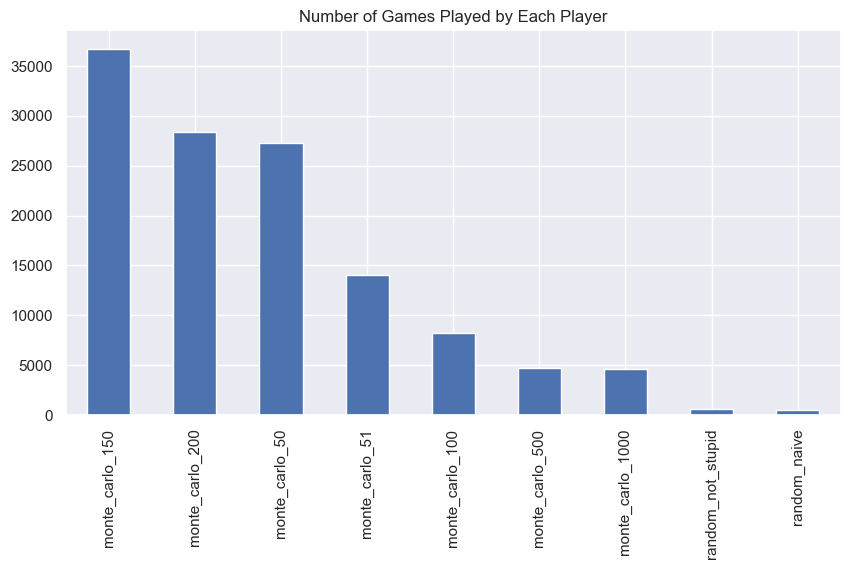

In [34]:
play_counts.plot(kind='bar', figsize=(10, 5), title='Number of Games Played by Each Player')

# Old

# Analysis

In [4]:
data_df = raw_data_df.copy()
data_df = data_df.drop(columns=['game_id'])

In [5]:
# Who won the most games? in %
data_df['winner_id'].value_counts(normalize=True) * 100

winner_id
monte_carlo_200      32.015971
monte_carlo_150      28.452989
monte_carlo_50       17.214720
monte_carlo_51       12.494596
monte_carlo_100       5.912871
Tie                   1.452150
monte_carlo_1000      1.027441
monte_carlo_500       1.022354
random_not_stupid     0.396735
random_naive          0.010173
Name: proportion, dtype: float64

In [6]:
# Create indicator columns  for all of the players 
players = list(set(data_df['player_one_id'].to_list() +  data_df['player_two_id'].to_list()))
players

for player in players:
    data_df[player] = (data_df['player_one_id'] == player) | (data_df['player_two_id'] == player)

data_df.head(2)

,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,monte_carlo_51,monte_carlo_1000,monte_carlo_200,monte_carlo_100,monte_carlo_500,random_naive,random_not_stupid,monte_carlo_150,monte_carlo_50
0,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaT,NaT,False,False,True,False,False,False,False,False,True
1,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaT,NaT,False,False,False,False,True,True,False,False,False


In [7]:
data_df[players].sum()

monte_carlo_51       10000
monte_carlo_1000       590
monte_carlo_200      24280
monte_carlo_100       4187
monte_carlo_500        552
random_naive           554
random_not_stupid      601
monte_carlo_150      23702
monte_carlo_50       14176
dtype: int64

In [8]:
players = [
 'random_naive',
 'random_not_stupid',
 'monte_carlo_50',
 'monte_carlo_100',
 'monte_carlo_200',
 'monte_carlo_500', 
 'monte_carlo_1000',
]


def calculate_win_rate(data_df, target_player):
    target_df = data_df[data_df[target_player]]
    results_df = pd.DataFrame(index=players)
    
    for player in players:
        if player == target_player:
            continue
        subset_df = target_df[target_df[player]]
        games_played = subset_df.shape[0]
        games_won = subset_df[subset_df['winner_id'] == target_player].shape[0]
        win_rate = games_won / games_played if games_played > 0 else 0
        results_df.loc[player, 'games_played'] = games_played
        results_df.loc[player, 'games_won'] = games_won
        results_df.loc[player, 'ties'] = subset_df[subset_df['winner_id'] == 'Tie'].shape[0]
        results_df.loc[player, 'win_rate'] = win_rate * 100
        results_df.loc[player, 'tie_rate'] = results_df.loc[player, 'ties'] / games_played * 100

    return results_df



for player in players:
    print(player)
    display(calculate_win_rate(data_df, player))


random_naive


,games_played,games_won,ties,win_rate,tie_rate
random_naive,NaN,NaN,NaN,NaN,NaN
random_not_stupid,102.0,4.0,0.0,3.921569,0.0
monte_carlo_50,83.0,0.0,0.0,0.000000,0.0
monte_carlo_100,84.0,0.0,0.0,0.000000,0.0
monte_carlo_200,105.0,0.0,0.0,0.000000,0.0
monte_carlo_500,68.0,0.0,0.0,0.000000,0.0
monte_carlo_1000,112.0,0.0,0.0,0.000000,0.0


random_not_stupid


,games_played,games_won,ties,win_rate,tie_rate
random_naive,102.0,98.0,0.0,96.078431,0.000000
random_not_stupid,NaN,NaN,NaN,NaN,NaN
monte_carlo_50,90.0,15.0,5.0,16.666667,5.555556
monte_carlo_100,98.0,13.0,2.0,13.265306,2.040816
monte_carlo_200,87.0,8.0,0.0,9.195402,0.000000
monte_carlo_500,105.0,10.0,1.0,9.523810,0.952381
monte_carlo_1000,119.0,12.0,0.0,10.084034,0.000000


monte_carlo_50


,games_played,games_won,ties,win_rate,tie_rate
random_naive,83.0,83.0,0.0,100.000000,0.000000
random_not_stupid,90.0,70.0,5.0,77.777778,5.555556
monte_carlo_50,NaN,NaN,NaN,NaN,NaN
monte_carlo_100,3719.0,1622.0,57.0,43.613875,1.532670
monte_carlo_200,98.0,35.0,2.0,35.714286,2.040816
monte_carlo_500,99.0,25.0,2.0,25.252525,2.020202
monte_carlo_1000,87.0,34.0,1.0,39.080460,1.149425


monte_carlo_100


,games_played,games_won,ties,win_rate,tie_rate
random_naive,84.0,84.0,0.0,100.000000,0.000000
random_not_stupid,98.0,83.0,2.0,84.693878,2.040816
monte_carlo_50,3719.0,2040.0,57.0,54.853455,1.532670
monte_carlo_100,NaN,NaN,NaN,NaN,NaN
monte_carlo_200,101.0,45.0,0.0,44.554455,0.000000
monte_carlo_500,101.0,40.0,0.0,39.603960,0.000000
monte_carlo_1000,84.0,33.0,0.0,39.285714,0.000000


monte_carlo_200


,games_played,games_won,ties,win_rate,tie_rate
random_naive,105.0,105.0,0.0,100.000000,0.000000
random_not_stupid,87.0,79.0,0.0,90.804598,0.000000
monte_carlo_50,98.0,61.0,2.0,62.244898,2.040816
monte_carlo_100,101.0,56.0,0.0,55.445545,0.000000
monte_carlo_200,NaN,NaN,NaN,NaN,NaN
monte_carlo_500,89.0,40.0,1.0,44.943820,1.123596
monte_carlo_1000,98.0,45.0,1.0,45.918367,1.020408


monte_carlo_500


,games_played,games_won,ties,win_rate,tie_rate
random_naive,68.0,68.0,0.0,100.000000,0.000000
random_not_stupid,105.0,94.0,1.0,89.523810,0.952381
monte_carlo_50,99.0,72.0,2.0,72.727273,2.020202
monte_carlo_100,101.0,61.0,0.0,60.396040,0.000000
monte_carlo_200,89.0,48.0,1.0,53.932584,1.123596
monte_carlo_500,NaN,NaN,NaN,NaN,NaN
monte_carlo_1000,90.0,59.0,1.0,65.555556,1.111111


monte_carlo_1000


,games_played,games_won,ties,win_rate,tie_rate
random_naive,112.0,112.0,0.0,100.000000,0.000000
random_not_stupid,119.0,107.0,0.0,89.915966,0.000000
monte_carlo_50,87.0,52.0,1.0,59.770115,1.149425
monte_carlo_100,84.0,51.0,0.0,60.714286,0.000000
monte_carlo_200,98.0,52.0,1.0,53.061224,1.020408
monte_carlo_500,90.0,30.0,1.0,33.333333,1.111111
monte_carlo_1000,NaN,NaN,NaN,NaN,NaN


## Turn Counts

<Axes: xlabel='turns', ylabel='Count'>

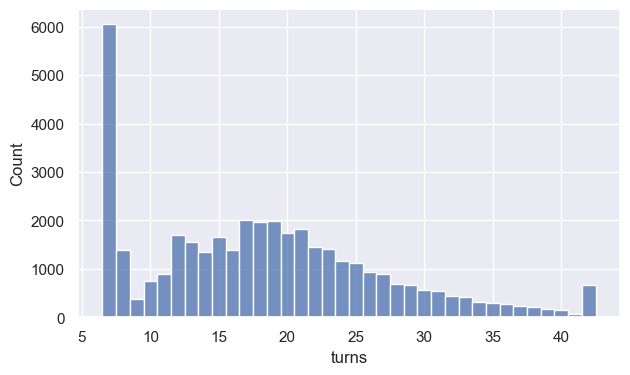

In [9]:
# turn_distribution = data_df.turns.value_counts()
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(data_df.turns, ax=ax,binwidth=1, discrete=True)